In [44]:
# ### Explanation of Code Sections:

# 1. Data Preparation and Exploration:
#    - The code starts with importing necessary libraries and preparing sample data.
#    - Data exploration functions (`describe`, `info`) provide an overview of the dataset.

# 2. Optimal Binning:
#    - `OptimalBinning` from the `optbinning` library is used to perform optimal binning on the PD scores.
#    - The binned data is then transformed and scored manually using WOE values.

# 3. Model Validation Technique
#    - **ROC Cue and AUC**: Evaluate the model's discriminatory pow.
#    - *rier Score**: Measure the accuracy of probabilistic predictis.
#    - **Calration Plot**: Visualize the alignment between predicted probabilities and actual outcomes.

# 4. Stability and Robuness:
#    - **Population Stabity Index (PSI)**: Measure the change in distribution of PD scores over time to assess model stability.

# 5. Reporting and Documentation:
#    - Results and plots should be documented.
#    - Save the binning process and scorepedictive analytics.


# Import Liberaries

In [27]:
import pandas as pd
import numpy as np
from optbinning import BinningProcess, OptimalBinning
from sklearn.metrics import roc_auc_score, brier_score_loss, roc_curve, auc
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.tree import DecisionTreeClassifier

# Sample Data (Replace with actual data)

In [28]:
data = pd.DataFrame({
    'pd_score': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'target': [0, 0, 0, 1, 1, 1, 1, 0, 1]
})

# 1. Data Preparation and Exploration

#### Understanding and cleaning the data

In [29]:
data.describe()  # Summary statistics
data.info()      # Data types and non-null counts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pd_score  9 non-null      float64
 1   target    9 non-null      int64  
dtypes: float64(1), int64(1)
memory usage: 276.0 bytes


# 2. Optimal Binning

#### Define the variable to be binned

In [30]:
variable = 'pd_score'

#### Create and fit the optimal binning process

In [31]:
optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")
optb.fit(data[variable], data['target'])

OptimalBinning(name='pd_score')

#### Transform the data using the fitted binning process

In [32]:
data['binned'] = optb.transform(data[variable], metric="bins")

#### Calculate WOE and apply to data

In [33]:
data['woe'] = optb.transform(data[variable], metric="woe")

#### Calculate score manually (e.g., using WOE values)

In [34]:
data['score'] = data['woe'] * 100  # Simple linear transformation example

#### Normalize the score to be between 0 and 1

In [35]:
score_min = data['score'].min()
score_max = data['score'].max()

#### Check for division by zero

In [36]:
if score_min == score_max:
    data['normalized_score'] = 0.5  # Assign a constant value if all scores are the same
else:
    data['normalized_score'] = (data['score'] - score_min) / (score_max - score_min)

# 3. Model Validation Techniques

## 3.1. Discriminatory Power

#### ROC Curve and AUC

In [37]:
fpr, tpr, _ = roc_curve(data['target'], data['normalized_score'])
roc_auc = auc(fpr, tpr)
print(f"ROC AUC Score: {roc_auc}")

ROC AUC Score: 0.5


#### Plot ROC Curve

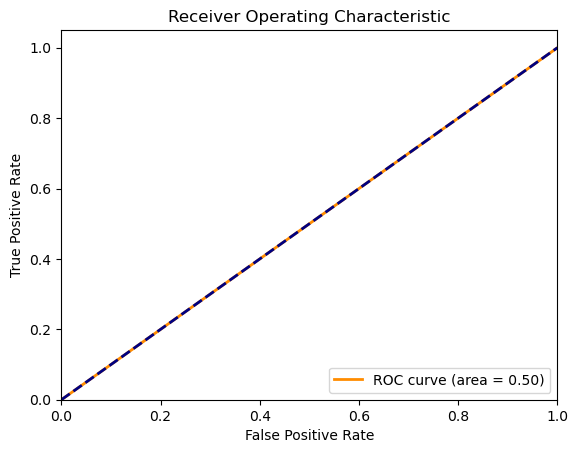

In [38]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# 3.2. Predictive Power

## Brier Score

In [39]:
brier = brier_score_loss(data['target'], data['normalized_score'])
print(f"Brier Score: {brier}")

Brier Score: 0.25


# 3.3. Calibration

#### Calibration Plot

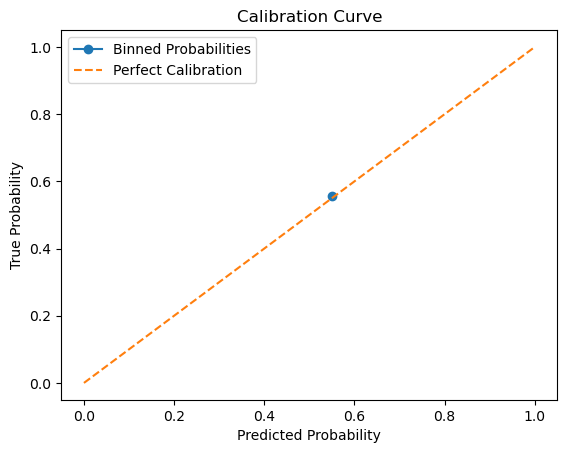

In [40]:
def plot_calibration_curve(y_true, y_prob, n_bins=10):
    bins = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_true_prob = np.zeros(n_bins)
    
    for i in range(n_bins):
        bin_mask = (y_prob >= bins[i]) & (y_prob < bins[i + 1])
        bin_true_prob[i] = y_true[bin_mask].mean()
    
    plt.figure()
    plt.plot(bin_centers, bin_true_prob, marker='o', label='Binned Probabilities')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Probability')
    plt.title('Calibration Curve')
    plt.legend()
    plt.show()

plot_calibration_curve(data['target'], data['normalized_score'])

# 4. Stability and Robustness

#### Population Stability Index (PSI) calculation

In [41]:
def calculate_psi(expected, actual, buckets=10):
    def scale_range(input, min, max):
        input += -(np.min(input))
        input /= np.max(input) / (max - min)
        input += min
        return input
    
    expected = scale_range(expected, 0, 1)
    actual = scale_range(actual, 0, 1)
    
    breakpoints = np.arange(0, buckets + 1) / (buckets) 
    
    expected_percents = np.histogram(expected, bins=breakpoints)[0] / len(expected)
    actual_percents = np.histogram(actual, bins=breakpoints)[0] / len(actual)
    
    def sub_psi(e_perc, a_perc):
        if a_perc == 0:
            a_perc = 0.0001
        if e_perc == 0:
            e_perc = 0.0001
        return (e_perc - a_perc) * np.log(e_perc / a_perc)
    
    psi_value = np.sum(sub_psi(expected_percents[i], actual_percents[i]) for i in range(0, len(expected_percents)))
    
    return psi_value

# Example PSI calculation

#### Compare distributions over time periods

In [42]:
expected_scores = data['normalized_score'][:5]  # e.g., Scores from a previous period
actual_scores = data['normalized_score'][5:]    # e.g., Scores from the current period
psi = calculate_psi(expected_scores, actual_scores)
print(f"Population Stability Index (PSI): {psi}")

Population Stability Index (PSI): 0.0


C:\Users\vincent.chandekar\AppData\Local\Temp\ipykernel_23140\2957285473.py:23: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  psi_value = np.sum(sub_psi(expected_percents[i], actual_percents[i]) for i in range(0, len(expected_percents)))


# 5. Reporting and Documentation

#### All results and plots should be documented and reported comprehensively

#### Save the binning process for future use

In [ ]:
import pickle
with open('binning_process.pkl', 'wb') as f:
    pickle.dump(optb, f)